In [188]:
import base64
from requests import post, get
import json


client_id = "05ba187e71a949f98361cfe8272c8a8c"
client_secret = "3de79f6ca9124a8785339527c0241b01"

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
        
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

# 获取headers
def get_auth_header(token):
    return {"Authorization": "Bearer " + token}


# 得出美国地区排名前20的歌曲风格
def get_genres(access_token, country='US', limit=20, offset=0):
    # 根据API提供的url
    genres_url = "https://api.spotify.com/v1/browse/categories"
    # 请求头
    headers = get_auth_header(access_token)
    # 请求参数
    params = {
        "country": country,
        "limit": limit,
        'offset': offset
    }
    # 获取数据
    response = get(genres_url, headers=headers, params=params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]

    return genres

# 初始化风格数组
genres = []
token = get_token()

# 获取genres数据
result = get_genres(token)

# 
for genre_id, genre in result:
    genres.append(f'genre:"{genre}"')

print(genres)



['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']


In [189]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
# 获取权限
client_id = "05ba187e71a949f98361cfe8272c8a8c"
client_secret = "3de79f6ca9124a8785339527c0241b01"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = get_token()


In [191]:
import pandas as pd
import time

# 计算每个歌曲风格排名前50的歌曲
def creat_frame(quert_list, limit=50):
    # 初始化数据库
    data = {
        'Track ID': [],
        'Track name': [],
        'Artist': [],
        'Popularity': [],
        'Release year': [],
        'Genres': []
    }
    
    for query in quert_list:
        search_result = sp.search(query, limit=limit, type='track')
        tracks = search_result['tracks']['items']

        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track name'].append(track['name'])
            data['Artist'].append(track['artists'][0]['name'])
            data['Popularity'].append(track['popularity'])
            data['Release year'].append(track['album']['release_date'][:4])
            data['Genres'].append(query)
            


    df = pd.DataFrame(data)
    return df

genres = ['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']
df = creat_frame(genres, limit=50)


In [192]:
df

,Track ID,Track name,Artist,Popularity,Release year,Genres
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop"""
1,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,92,2023,"genre:""Hip-Hop"""
2,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop"""
3,68Dni7IE4VyPkTOH9mRWHr,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop"""
4,4rXLjWdF2ZZpXCVTfWcshS,fukumean,Gunna,93,2023,"genre:""Hip-Hop"""
...,...,...,...,...,...,...
695,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming"""
696,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming"""
697,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming"""
698,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,55,2021,"genre:""Gaming"""


In [212]:
# 获取音频特征
def get_audio_features(track_ids):
    features_list =[]#按批次获取特征数据
    for i in range(0, len(track_ids), 50):
        batch = track_ids[i:i+50]
        features_results = sp.audio_features(batch)
        features_list += features_results
    return features_list

In [213]:
track_ids = df['Track ID'].tolist()
audio_features = get_audio_features(track_ids)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=4xhsWYTOGcal8zt0J161CU,2YSzYUF3jWqb9YP9VXmpjE,7aqfrAY2p9BUSiupwk3svU,68Dni7IE4VyPkTOH9mRWHr,4rXLjWdF2ZZpXCVTfWcshS,1udwFobQ1JoOdWPQrp2b6u,6wsqVwoiVH2kde4k4KKAFU,7KA4W4McWYRpgf0fWsJZWB,3xKsf9qdS1CyvXSMEid6g8,1yeB8MUNeLo9Ek1UEpsyz6,3F5CgOj3wFlRv51JsHbxhe,2HbKqm4o0w5wEeEFXm2sD4,4EWCNWgDS8707fNSZ1oaA5,6pcywuOeGGWeOQzdUyti6k,4tqcoej1zPvwePZCzuAjJd,4KW1lqgSr8TKrvBII0Brf8,5TRPicyLGbAF2LGBFbHGvO,42VsgItocQwOQC3XWZ8JNA,67nepsnrcZkowTxMWigSbb,1i9lZvlaDdWDPyXEE95aiq,1bDbXMyjaUIooNwFE9wn0N,7sO5G9EABYOXQKNPNiE9NR,3DK6m7It6Pw857FcQftMds,59nOXPmaKlBfGMDeOVGrIK,7rbECVPkY5UODxoOUVKZnA,0YsGMHid6sFq5PcToe3JZE,3azJifCSqg9fRij2yKIbWz,4lH6nENd1y81jp7Yt9lTBX,2wAJTrFhCnQyNSD3oUgTZO,6PGoSes0D9eUDeeAafB2As,3eP13S8D5m2cweMEg3ZDed,7EiZI6JVHllARrX9PUvAdX,5Se32hEA9raeboZerywxka,7FIWs0pqAYbP91WWM0vlTQ,3yfqSUWxFvZELEM4PmlwIR,5mCPDVBb16L4XQwDdbRUpz,2JvzF1RMd7lE3KmFlsyZD8,3pXF1nA74528Edde4of9CC,7lQ8MOhq6IN2w8EYcFNSUk,2XHzzp1j4IfTNp1FTn7YFg,2ZL7WZcjuYKi1KUDtp4kCC,3sNVsP50132BTNlImLx70i,5FkoSXiJPKTNyYgALRJFhD,6IZvVAP7VPPnsGX6bvgkqg,4osgfFTICMkcGbbigdsa53,7aRCf5cLOFN1U7kvtChY1G,50a8bKqlwDEqeiEknrzkTO,1zi7xx7UVEFkmKfv06H8x0,5BbdKBZO0TH0GhfxUfyhL9,5SWnsxjhdcEDc7LJjq9UHk:
 Max Retries, reason: too many 429 error responses

In [180]:
audio_features_df = pd.DataFrame(audio_features)

AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
audio_features_df

In [14]:
# 合并两个表格，原始表格在左
merged_df = df.merge(audio_features_df, left_on='Track ID', right_on='id', how='inner')
merged_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
1,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
2,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Pop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
3,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Pop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
4,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,92,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,...,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,...,0.1370,0.1480,150.063,audio_features,4nCW3tSl82LPbmrrwYpF4b,spotify:track:4nCW3tSl82LPbmrrwYpF4b,https://api.spotify.com/v1/tracks/4nCW3tSl82LP...,https://api.spotify.com/v1/audio-analysis/4nCW...,227200,4
774,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,...,0.3200,0.3670,99.997,audio_features,3aYidIc6HUMrL1tFTmokSZ,spotify:track:3aYidIc6HUMrL1tFTmokSZ,https://api.spotify.com/v1/tracks/3aYidIc6HUMr...,https://api.spotify.com/v1/audio-analysis/3aYi...,176100,4
775,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,...,0.6650,0.3510,74.980,audio_features,4hAb4pbqgfgwraiHongYZR,spotify:track:4hAb4pbqgfgwraiHongYZR,https://api.spotify.com/v1/tracks/4hAb4pbqgfgw...,https://api.spotify.com/v1/audio-analysis/4hAb...,217787,4
776,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,55,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,...,0.2160,0.3990,174.985,audio_features,2bjtlNmO8Rf5Bl4rxNl3GJ,spotify:track:2bjtlNmO8Rf5Bl4rxNl3GJ,https://api.spotify.com/v1/tracks/2bjtlNmO8Rf5...,https://api.spotify.com/v1/audio-analysis/2bjt...,177782,4


In [15]:
# 去重处理
uni_df = merged_df.drop_duplicates(subset='Track ID', keep='first')

In [16]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,...,0.0937,0.6060,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4
4,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,92,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,...,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
8,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop""",0.470,0.640,2,-7.779,...,0.3820,0.2480,163.920,audio_features,7aqfrAY2p9BUSiupwk3svU,spotify:track:7aqfrAY2p9BUSiupwk3svU,https://api.spotify.com/v1/tracks/7aqfrAY2p9BU...,https://api.spotify.com/v1/audio-analysis/7aqf...,247444,4
12,68Dni7IE4VyPkTOH9mRWHr,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop""",0.690,0.521,10,-8.492,...,0.0534,0.4940,100.028,audio_features,68Dni7IE4VyPkTOH9mRWHr,spotify:track:68Dni7IE4VyPkTOH9mRWHr,https://api.spotify.com/v1/tracks/68Dni7IE4VyP...,https://api.spotify.com/v1/audio-analysis/68Dn...,292799,4
13,4rXLjWdF2ZZpXCVTfWcshS,fukumean,Gunna,93,2023,"genre:""Hip-Hop""",0.847,0.622,1,-6.747,...,0.2850,0.2200,130.001,audio_features,4rXLjWdF2ZZpXCVTfWcshS,spotify:track:4rXLjWdF2ZZpXCVTfWcshS,https://api.spotify.com/v1/tracks/4rXLjWdF2ZZp...,https://api.spotify.com/v1/audio-analysis/4rXL...,125040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,...,0.1370,0.1480,150.063,audio_features,4nCW3tSl82LPbmrrwYpF4b,spotify:track:4nCW3tSl82LPbmrrwYpF4b,https://api.spotify.com/v1/tracks/4nCW3tSl82LP...,https://api.spotify.com/v1/audio-analysis/4nCW...,227200,4
774,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,...,0.3200,0.3670,99.997,audio_features,3aYidIc6HUMrL1tFTmokSZ,spotify:track:3aYidIc6HUMrL1tFTmokSZ,https://api.spotify.com/v1/tracks/3aYidIc6HUMr...,https://api.spotify.com/v1/audio-analysis/3aYi...,176100,4
775,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,...,0.6650,0.3510,74.980,audio_features,4hAb4pbqgfgwraiHongYZR,spotify:track:4hAb4pbqgfgwraiHongYZR,https://api.spotify.com/v1/tracks/4hAb4pbqgfgw...,https://api.spotify.com/v1/audio-analysis/4hAb...,217787,4
776,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,55,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,...,0.2160,0.3990,174.985,audio_features,2bjtlNmO8Rf5Bl4rxNl3GJ,spotify:track:2bjtlNmO8Rf5Bl4rxNl3GJ,https://api.spotify.com/v1/tracks/2bjtlNmO8Rf5...,https://api.spotify.com/v1/audio-analysis/2bjt...,177782,4


In [17]:
# 去除无用的数据
drop_need = ['id', 'uri', 'track_href', 'analysis_url', 'type']
uni_df = uni_df.drop(columns=drop_need, axis=1)

In [18]:
# 对数据进行重新编号
uni_df.reset_index(drop=True, inplace=True)


In [19]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,1,0.0568,0.002600,0.000002,0.0937,0.6060,104.983,138411,4
1,2YSzYUF3jWqb9YP9VXmpjE,IDGAF (feat. Yeat),Drake,92,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,1,0.2710,0.046400,0.000089,0.2050,0.1380,136.952,260111,4
2,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop""",0.470,0.640,2,-7.779,1,0.3200,0.027700,0.000000,0.3820,0.2480,163.920,247444,4
3,68Dni7IE4VyPkTOH9mRWHr,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop""",0.690,0.521,10,-8.492,0,0.3390,0.324000,0.000000,0.0534,0.4940,100.028,292799,4
4,4rXLjWdF2ZZpXCVTfWcshS,fukumean,Gunna,93,2023,"genre:""Hip-Hop""",0.847,0.622,1,-6.747,0,0.0903,0.119000,0.000000,0.2850,0.2200,130.001,125040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,4nCW3tSl82LPbmrrwYpF4b,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,0,0.0656,0.001390,0.829000,0.1370,0.1480,150.063,227200,4
659,3aYidIc6HUMrL1tFTmokSZ,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,1,0.0989,0.012200,0.000525,0.3200,0.3670,99.997,176100,4
660,4hAb4pbqgfgwraiHongYZR,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,1,0.2170,0.040300,0.000252,0.6650,0.3510,74.980,217787,4
661,2bjtlNmO8Rf5Bl4rxNl3GJ,Omen,Cartoon,55,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,0,0.0425,0.045800,0.000054,0.2160,0.3990,174.985,177782,4


In [59]:
## Question 1: What are the top 10 genres?

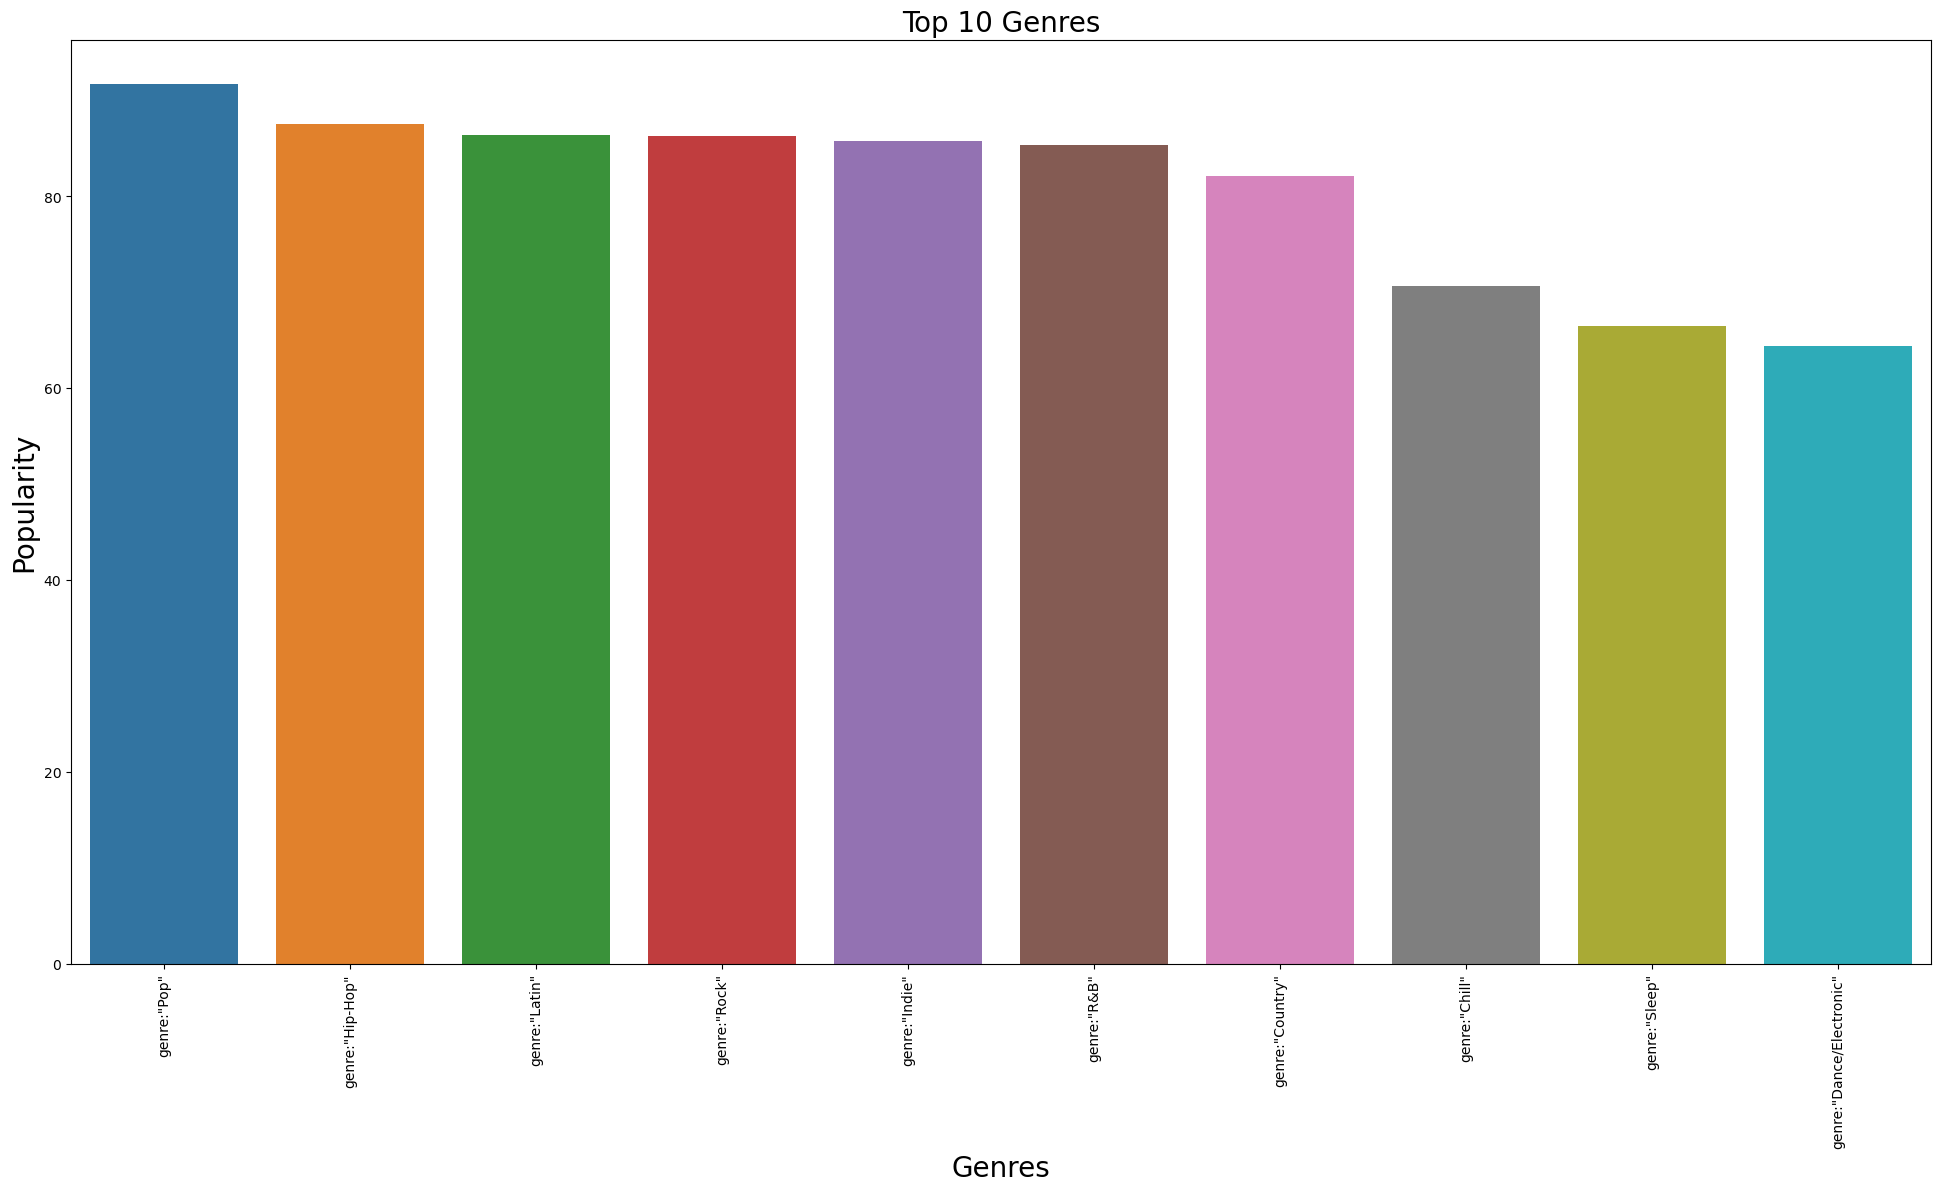

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average score for each genre
popularity_genre = uni_df.groupby('Genres')['Popularity'].mean().reset_index()

# Average scores obtained by sorting in descending order
popularity_genre = popularity_genre.sort_values('Popularity', ascending=False)

# Selection of top 10 data
popularity_top = popularity_genre.head(10)

# Setting the canvas size
plt.figure(figsize=(24,12))

# Plotting histograms, setting axes and values
sns.barplot(x='Genres', y='Popularity', data=popularity_top)
plt.xlabel('Genres', fontsize=20)
plt.ylabel('Popularity', fontsize=20)

# Setting the title
plt.title('Top 10 Genres',fontsize=20)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

plt.show()



In [76]:
drop_columns = ['Track ID', 'duration_ms', 'time_signature']
# 去除无关的列
final_df = uni_df.drop(columns=drop_columns)
final_df

,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Lovin On Me,Jack Harlow,97,2023,"genre:""Hip-Hop""",0.943,0.558,2,-4.911,1,0.0568,0.002600,0.000002,0.0937,0.6060,104.983
1,IDGAF (feat. Yeat),Drake,92,2023,"genre:""Hip-Hop""",0.663,0.670,8,-8.399,1,0.2710,0.046400,0.000089,0.2050,0.1380,136.952
2,First Person Shooter (feat. J. Cole),Drake,91,2023,"genre:""Hip-Hop""",0.470,0.640,2,-7.779,1,0.3200,0.027700,0.000000,0.3820,0.2480,163.920
3,No Role Modelz,J. Cole,91,2014,"genre:""Hip-Hop""",0.690,0.521,10,-8.492,0,0.3390,0.324000,0.000000,0.0534,0.4940,100.028
4,fukumean,Gunna,93,2023,"genre:""Hip-Hop""",0.847,0.622,1,-6.747,0,0.0903,0.119000,0.000000,0.2850,0.2200,130.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,HAPPY SONG,Ray Volpe,49,2023,"genre:""Gaming""",0.570,0.960,6,-1.986,0,0.0656,0.001390,0.829000,0.1370,0.1480,150.063
659,Phenomenon,Unknown Brain,56,2020,"genre:""Gaming""",0.700,0.878,0,-5.133,1,0.0989,0.012200,0.000525,0.3200,0.3670,99.997
660,Shiawase,Dion Timmer,53,2018,"genre:""Gaming""",0.606,0.952,8,-2.004,1,0.2170,0.040300,0.000252,0.6650,0.3510,74.980
661,Omen,Cartoon,55,2021,"genre:""Gaming""",0.486,0.872,10,-5.056,0,0.0425,0.045800,0.000054,0.2160,0.3990,174.985


In [ ]:
## Question 2: What kind of style has always been popular?

C:\Users\samuel\AppData\Local\Temp\ipykernel_33164\505893654.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')


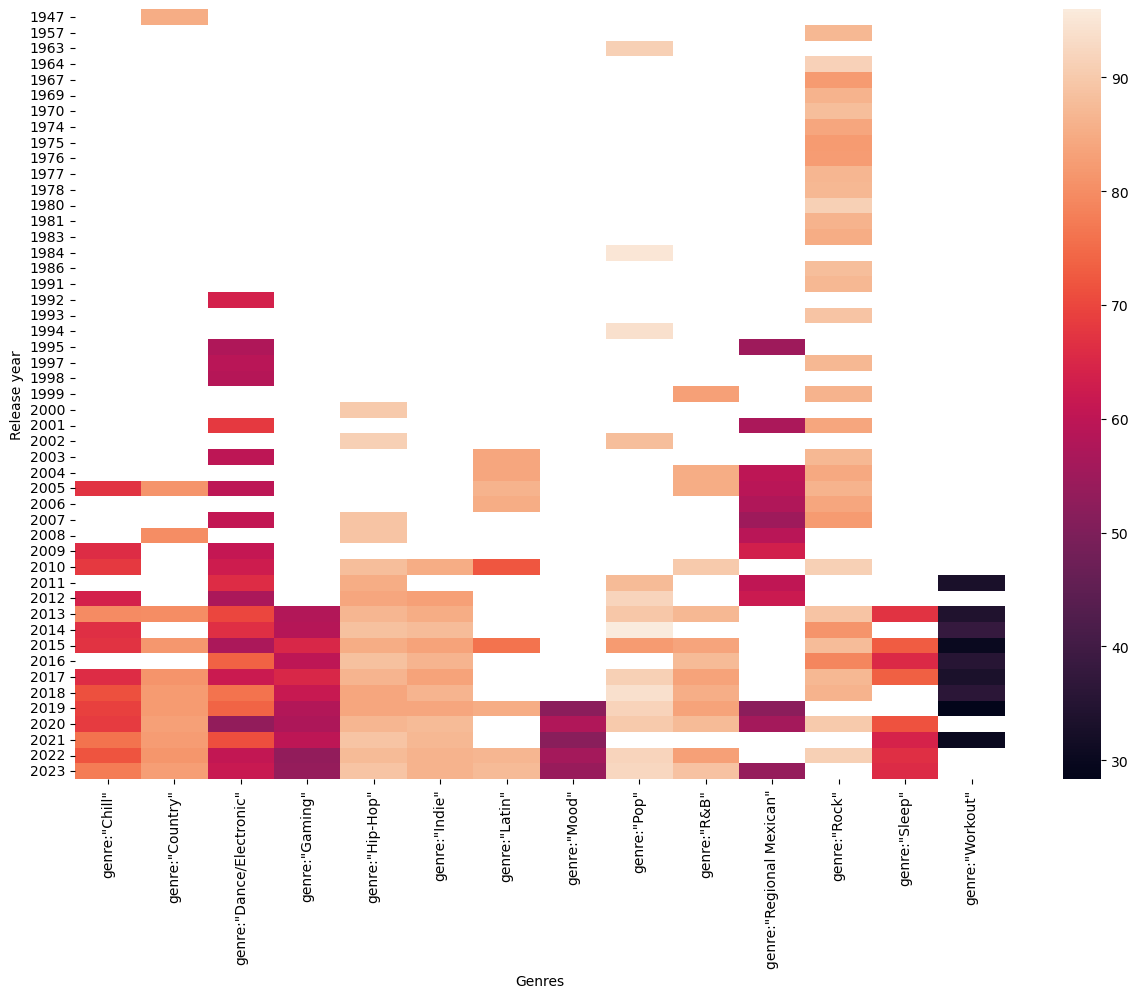

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns


# genre_popularity = filtered_df.groupby('Genres')['Popularity'].mean().reset_index()
# genre_popularity = genre_popularity.sort_values('Popularity', ascending=False)
# top_10 = popularity_top['Genres'].values
# # print(top_10)
# df = final_df[final_df['Genres'].isin(top_10)]

# Grouping of years to prevent overlap
final_df['Release year'] = final_df['Release year'].astype(int)
# Grouping by year and style and calculating popularity for each group
year_genre_popularity = final_df.groupby(['Release year', 'Genres'])['Popularity'].mean().reset_index()
# print(year_genre_popularity)
matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')
plt.figure(figsize=(15,10))
sns.heatmap(matrix)
# sns.lineplot(x='Release year', y='Popularity', hue='Genres', data=year_genre_popularity)
plt.show()

# As you can see, "Rock" has been popular for years.

In [ ]:
## Question 3: What melodic song is better for healing the heart when you're not in a happy mood?(improve energy)
## Question 4: Does song popularity correlate with audio features?
## Question 5: Which features are more correlated with each other?

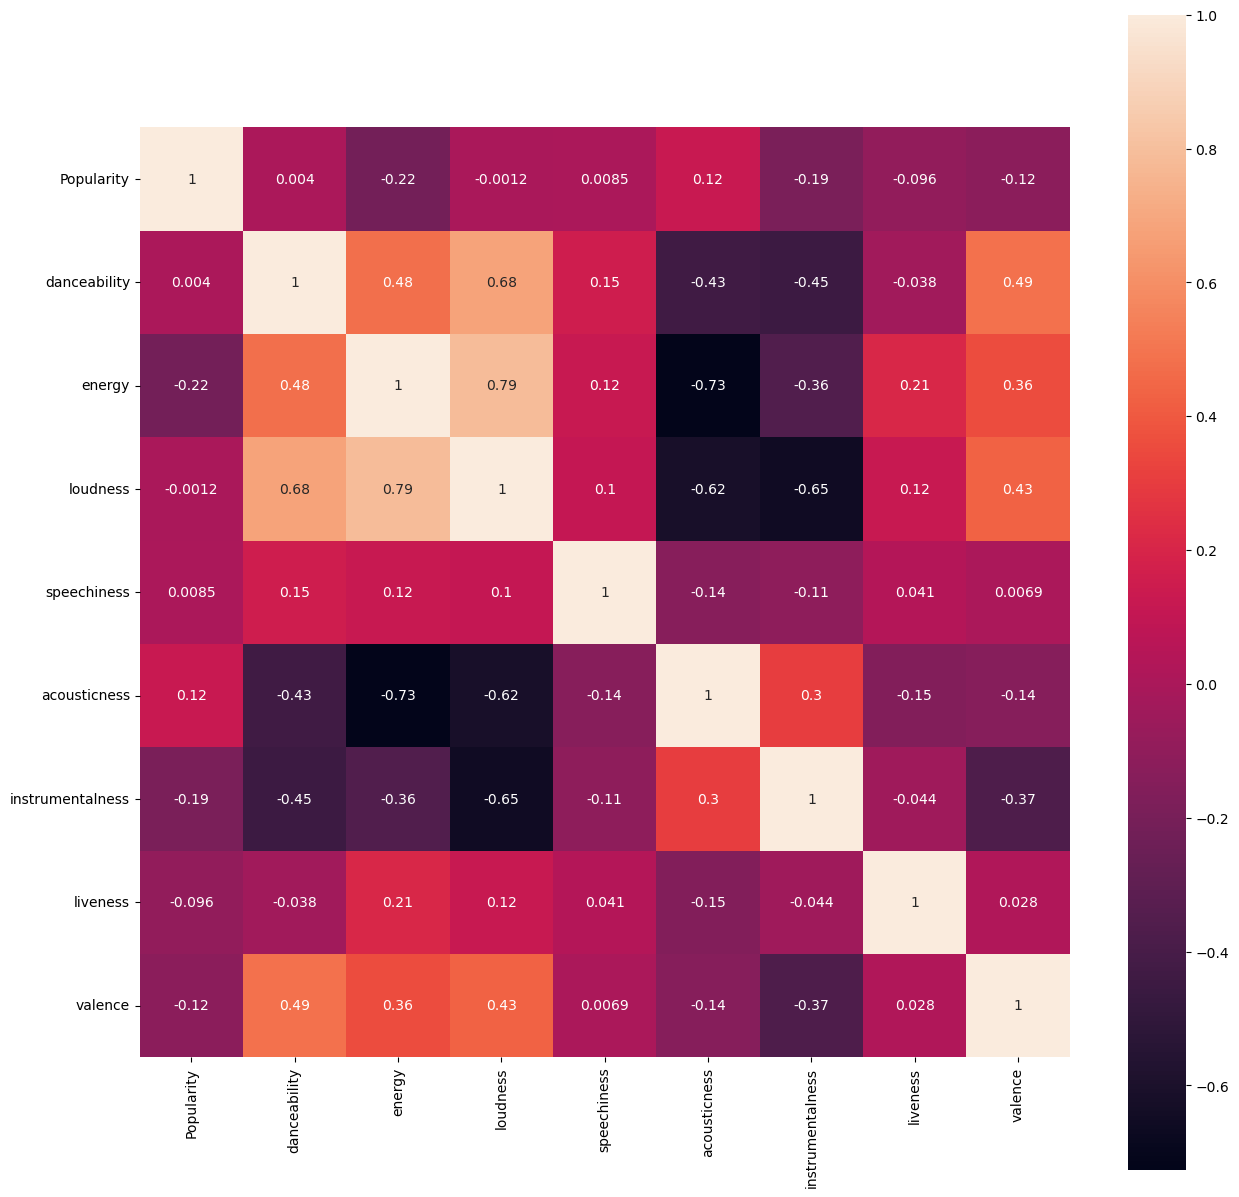

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
# Selection of features
features = ['Popularity', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# Formation of the feature matrix
matrix = final_df[features].corr()
# Define image size
plt.figure(figsize=(15,15))
# Heat mapping
sns.heatmap(matrix, annot=True, square=True)
plt.show()